In [1]:
# !pip install scikit-plot

In [2]:
import math

import matplotlib.pylab as plt
import pandas as pd

# from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import train_test_split

from dmba import load_data
from dmba.charts import gains_chart, lift_chart
from dmba.metrics import regression_summary

## Prediction error metrics from a model for Toyota car prices. Training and validation

In [3]:
# Reduce data frame to the top 1000 rows and select columns for regression analysis.
car_df = load_data("ToyotaCorolla.csv")
car_df.sample(5)

,id,model,price,age_08_04,mfg_month,mfg_year,km,fuel_type,hp,met_color,...,powered_windows,power_steering,radio,mistlamps,sport_model,backseat_divider,metallic_rim,radio_cassette,parking_assistant,tow_bar
20,21,TOYOTA Corolla 1.6 16V VVT I 3DR TERRA 2/3-Doors,15950,30,3,2002,67660,Petrol,110,1,...,1,1,0,0,1,1,0,0,0,1
586,590,TOYOTA Corolla 1.3 16V HATCHB G6 2/3-Doors,9950,55,2,2000,29650,Petrol,86,0,...,1,1,0,1,1,1,0,0,0,1
251,253,TOYOTA Corolla 1.6 16V VVT I SEDAN TERRA 4/5-D...,10850,43,2,2001,54600,Petrol,110,0,...,0,1,0,0,0,1,0,0,0,0
93,94,TOYOTA Corolla 1.4 16V VVT I 3DR TERRA COMFORT...,15950,20,1,2003,33329,Petrol,97,1,...,1,1,0,0,1,1,0,0,0,0
1085,1091,TOYOTA Corolla 2.0 DSL LIFTB LINEA LUNA 4/5-Doors,7950,79,2,1998,131500,Diesel,72,0,...,1,1,0,1,0,1,0,0,0,0


In [4]:
# Create a list of predictor variables by removing output variables and text columns
X = car_df.drop(columns=["price", "id", "model", "fuel_type", "color"], axis=1)
y = car_df["price"]

# Partition data.
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [5]:
# Train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

LinearRegression()

In [6]:
regression_summary(train_y, reg.predict(train_X))

RMSE: 1256776.8345910097
MAE: 811.6770003906788


<AxesSubplot:title={'center':'residual'}, xlabel='[data set]'>

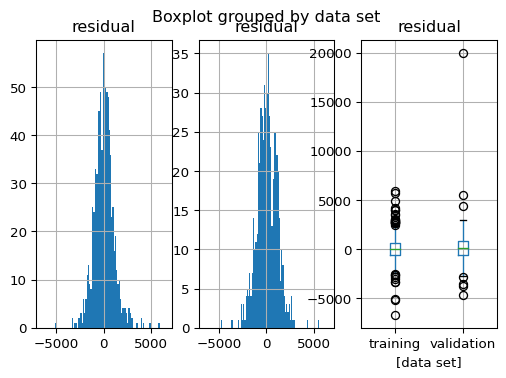

In [7]:
pred_error_train = pd.DataFrame(
    {"residual": train_y - reg.predict(train_X), "data set": "training"}
)
pred_error_test = pd.DataFrame(
    {"residual": test_y - reg.predict(test_X), "data set": "validation"}
)
boxdata_df = pred_error_train.append(pred_error_test, ignore_index=True)
_fig, axes = plt.subplots(nrows=1, ncols=3)
common = {"bins": 100, "range": [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_test.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by="data set")

In [8]:
# Histograms and boxplots of Toyota price prediction errors, for training and validation sets.

## Gain and lift charts


Gain and lift charts are visual aid for evaluating performance of classification models.


How does it differ from confusion matrix?
- confusion matrix: evaluates the overall population
- gain and lift chart: evaluates model performance in a portion of the population

In short, we evaluate the model in terms of benefit we could get using the model in a portion of the population.


Reference:
1.  https://towardsdatascience.com/model-benefit-evaluation-with-lift-and-gain-analysis-4b69f9288ab3#:~:text=Gain%20and%20lift%20charts%20are,a%20portion%20of%20the%20population.
2. http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html
3. https://www.geeksforgeeks.org/understanding-gain-chart-and-lift-chart/
4. https://www.listendata.com/2014/08/excel-template-gain-and-lift-charts.html
5. https://select-statistics.co.uk/blog/cumulative-gains-and-lift-curves-measuring-the-performance-of-a-marketing-campaign/

In [9]:
# Difference between pd.qcut and pd.cut
# pd.cut partition equally by values
# pd.qcut partition equally by dataset

numbers = [
    1,
    1,
    1,
    2,
    2,
    3,
    4,
    5,
    6,
]
pd.qcut(numbers, 3, labels=False), pd.cut(numbers, 3, labels=False)

(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 0, 0, 0, 0, 1, 1, 2, 2]))

In [10]:
pred_df = pd.DataFrame(reg.predict(test_X), columns=["y_pred"], index=test_X.index)
pred_df.sort_values(by="y_pred", ascending=False, inplace=True)

# Divide the data into deciles: divide the data into 10 sets and label it.
# qcut bins the data into different group. However, the largest values will be labelled decile 10 instead of 1, that is why we inverse the range.
pred_df["decile"] = pd.qcut(pred_df.y_pred, 10, labels=[i for i in range(10, 0, -1)])
lift_df = (
    pred_df.groupby("decile")
    .y_pred.agg(pred=("mean"), count=("count"))
    .reset_index()
    .sort_values("decile", ascending=False)
)
lift_df["decile_percent"] = lift_df.decile.astype(int) * 10
lift_df["cumulative"] = lift_df.pred.cumsum()
lift_df["gain"] = lift_df.cumulative / lift_df.cumulative.max() * 100
lift_df["lift"] = lift_df.gain / lift_df.decile_percent
lift_df

,decile,pred,count,decile_percent,cumulative,gain,lift
9,1,18514.313292,58,10,18514.313292,17.523277,1.752328
8,2,13551.618082,57,20,32065.931373,30.349502,1.517475
7,3,11923.397035,58,30,43989.328408,41.634662,1.387822
6,4,10778.656149,57,40,54767.984557,51.836357,1.295909
5,5,10191.693253,57,50,64959.677810,61.482508,1.229650
4,6,9587.440873,58,60,74547.118683,70.556751,1.175946
3,7,8917.324345,57,70,83464.443028,78.996748,1.128525
2,8,8253.960950,58,80,91718.403978,86.808890,1.085111
1,9,7547.928830,57,90,99266.332808,93.952792,1.043920
0,10,6389.210578,58,100,105655.543386,100.000000,1.000000


Text(0.5, 1.0, 'Gain Chart')

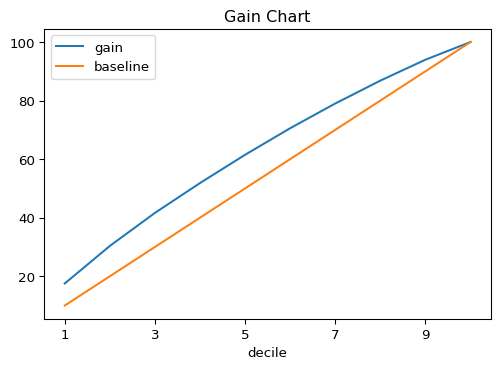

In [11]:
ax = lift_df.plot(x="decile", y=["gain", "decile_percent"])
ax.legend(["gain", "baseline"])
plt.title("Gain Chart")

Text(0.5, 1.0, 'Lift Chart')

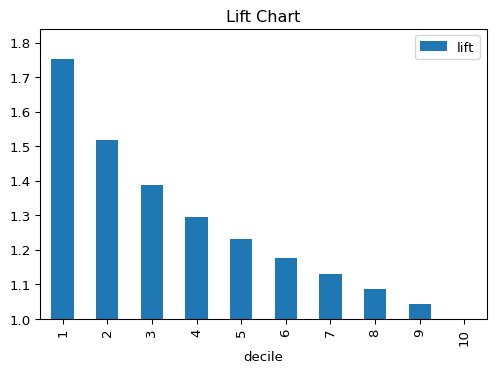

In [12]:
ax = lift_df.plot.bar(x="decile", y="lift")
ax.set_ylim(1)  # Start from 1
plt.title("Lift Chart")

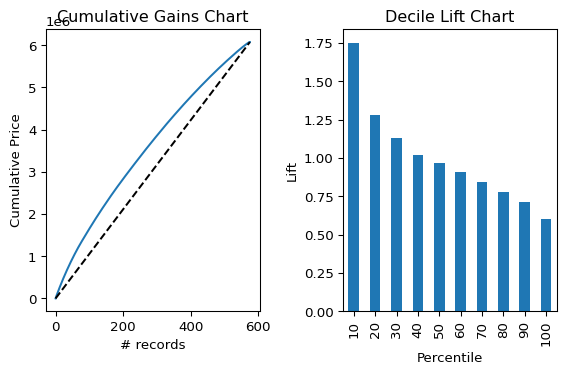

In [13]:
pred_v = pd.Series(reg.predict(test_X))
pred_v = pred_v.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gains_chart(pred_v, ax=axes[0])
ax.set_ylabel("Cumulative Price")
ax.set_title("Cumulative Gains Chart")

ax = lift_chart(pred_v, ax=axes[1], labelBars=False)
ax.set_ylabel("Lift")

plt.tight_layout()

## Confusion matrix based on cutoffs of 0.5, 0.25 and 0.75 

In [14]:
owner_df = load_data("ownerExample.csv")
owner_df.columns = ["type", "probability"]
owner_df.head()

,type,probability
0,owner,0.9959
1,owner,0.9875
2,owner,0.9844
3,owner,0.9804
4,owner,0.9481


In [15]:
def classify(cutoff):
    predicted = ["owner" if p > cutoff else "nonowner" for p in owner_df.probability]
    print(
        classification_report(
            predicted, owner_df.type, target_names=["nonowner", "owner"]
        )
    )
    disp = ConfusionMatrixDisplay(
        confusion_matrix(predicted, owner_df.type),
        display_labels=["nonowner", "owner"],
    )
    disp.plot()

              precision    recall  f1-score   support

    nonowner       0.83      0.91      0.87        11
       owner       0.92      0.85      0.88        13

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24



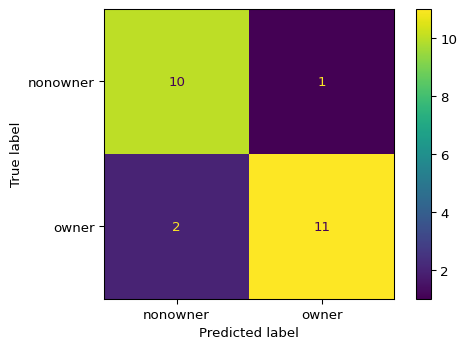

In [16]:
classify(0.5)

              precision    recall  f1-score   support

    nonowner       0.67      0.89      0.76         9
       owner       0.92      0.73      0.81        15

    accuracy                           0.79        24
   macro avg       0.79      0.81      0.79        24
weighted avg       0.82      0.79      0.79        24



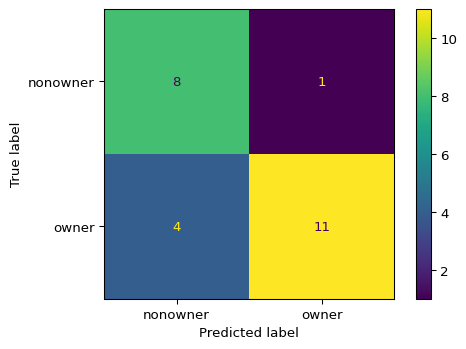

In [17]:
classify(0.25)

              precision    recall  f1-score   support

    nonowner       0.92      0.69      0.79        16
       owner       0.58      0.88      0.70         8

    accuracy                           0.75        24
   macro avg       0.75      0.78      0.74        24
weighted avg       0.81      0.75      0.76        24



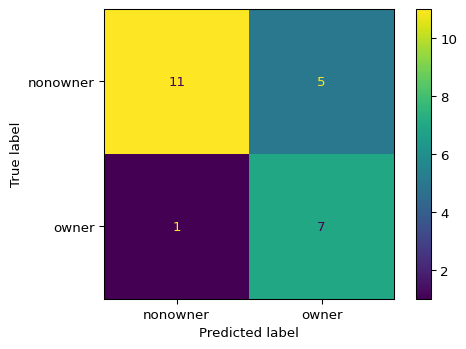

In [18]:
classify(0.75)

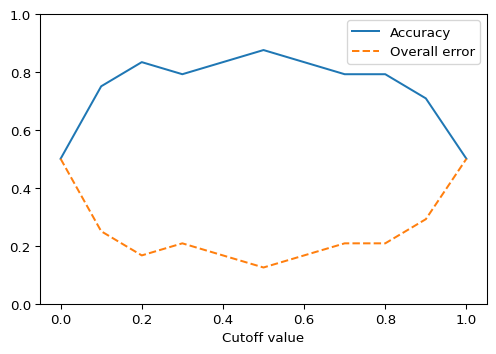

In [19]:
# Plotting accuracy and overall error as a function of the cutoff value (riding mowers example)

df = load_data("liftExample.csv")
cutoffs = [i * 0.1 for i in range(11)]
scores = []
for cutoff in cutoffs:
    predicted = [1 if p > cutoff else 0 for p in df.prob]
    scores.append(accuracy_score(df.actual, predicted))

line_accuracy = plt.plot(cutoffs, scores, "-", label="Accuracy")[0]
line_error = plt.plot(
    cutoffs, [1 - acc for acc in scores], "--", label="Overall error"
)[0]
plt.ylim([0, 1])
plt.xlabel("Cutoff value")
plt.legend(handles=[line_accuracy, line_error])

## ROC curve for riding mowers example.

In [20]:
from sklearn.metrics import auc, roc_curve

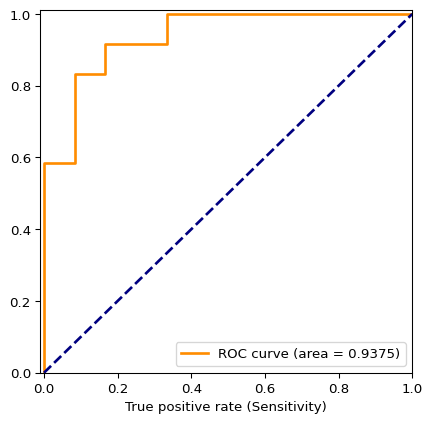

In [21]:
# compute ROC curve and AUC
fpr, tpr, _ = roc_curve(df.actual, df.prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1])
plt.ylim([0.0, 1.01])
plt.xlabel("False positive rate (1 - Specificity)")
plt.xlabel("True positive rate (Sensitivity)")
plt.legend(loc="lower right")

In [22]:
df = df.sort_values(by="prob", ascending=False)
df.head()

,prob,actual
1,0.998,1
0,0.995,1
2,0.985,1
3,0.980,1
4,0.948,1


Text(0.5, 1.0, 'Gain chart')

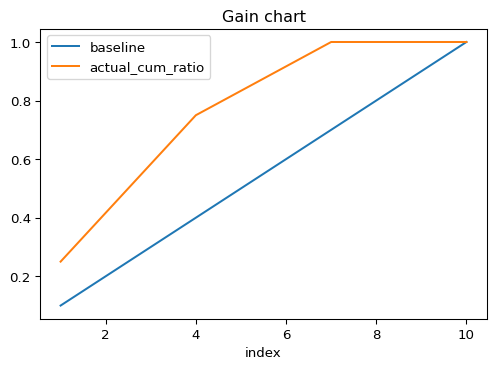

In [23]:
grouped_df = (
    df.groupby([int(10 * i / df.prob.size) + 1 for i in range(df.prob.size)])
    .actual.sum()
    .reset_index()
)
grouped_df["actual_cum"] = grouped_df.actual.cumsum()
grouped_df["actual_cum_ratio"] = grouped_df.actual_cum / grouped_df.actual_cum.max()
# This is the index (grouped_df.index), this is with the column named index (grouped_df["index"])
grouped_df["baseline"] = grouped_df["index"] / 10.0
ax = grouped_df.plot(x="index", y=["baseline", "actual_cum_ratio"])
ax.set_title("Gain chart")